https://www.wisnupriambodo.com/

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/sample_data/catvdog/cats_and_dogs_filtered.zip

--2022-12-07 11:47:32--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’

/content/sample_dat 100%[===================>]  65.43M  22.0MB/s    in 3.0s    

2022-12-07 11:47:36 (22.0 MB/s) - ‘/content/sample_data/catvdog/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/content/sample_data/catvdog/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/sample_data/catvdog')
zip_ref.close()

In [ ]:
base_dir = '/content/sample_data/catvdog/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Import all dependencies

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torchvision.datasets as datasets # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader, Dataset # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
from PIL import Image

Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu or cpu

In [ ]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder("/content/sample_data/catvdog/cats_and_dogs_filtered/train/")
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB 
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory
        
    
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # train transform

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)
]) # test transform

train_dataset = ImageLoader(train_data, train_transform)
test_dataset = ImageLoader(test_data, test_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
from tqdm import tqdm
from torchvision import models
# load pretrain model and modify...
model = models.resnet50(pretrained=True)

# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Train and test

def train(num_epoch, model):
    for epoch in range(0, num_epoch):
#         current_loss = 0.0
#         current_corrects = 0
        losses = []
        model.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader)) # create a progress bar
        for batch_idx, (data, targets) in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            scores = model(data)
            
            loss = criterion(scores, targets)
            optimizer.zero_grad()
            losses.append(loss)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(scores, 1)
#             current_loss += loss.item() * data.size(0)
#             current_corrects += (preds == targets).sum().item()
#             accuracy = int(current_corrects / len(train_loader.dataset) * 100)
            loop.set_description(f"Epoch {epoch+1}/{num_epoch} process: {int((batch_idx / len(train_loader)) * 100)}")
            loop.set_postfix(loss=loss.data.item())
        
        # save model
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, 'checpoint_epoch_'+str(epoch)+'.pt')


        
# model.eval() is a kind of switch for some specific layers/parts of the model that behave differently,
# during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc. 
# You need to turn off them during model evaluation, and .eval() will do it for you. In addition, 
# the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() 
# to turn off gradients computation:
        
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            _, predictions = torch.max(output, 1)
            correct += (predictions == y).sum().item()
            test_loss = criterion(output, y)
            
    test_loss /= len(test_loader.dataset)
    print("Average Loss: ", test_loss, "  Accuracy: ", correct, " / ",
    len(test_loader.dataset), "  ", int(correct / len(test_loader.dataset) * 100), "%")

In [ ]:
if __name__ == "__main__":
    train(5, model) # train
    test() # test

Epoch 5/5 process: 96: 100%|██████████| 25/25 [06:01<00:00, 14.46s/it, loss=0.125]


Average Loss:  tensor(2.1031e-05)   Accuracy:  388  /  400    97 %


In [ ]:
print("----> Loading checkpoint")
checkpoint = torch.load("./checpoint_epoch_4.pt") # Try to load last checkpoint
model.load_state_dict(checkpoint["model_state_dict"]) 
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

----> Loading checkpoint


In [ ]:
# Check the test set
dataset = ImageFolder("/content/sample_data/catvdog/cats_and_dogs_filtered/validation", 
                     transform=transforms.Compose([
                         transforms.Resize((224, 224)), 
                         transforms.ToTensor(), 
                         transforms.Normalize([0.5]*3, [0.5]*3)
                     ]))
print(dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle = False)

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: /content/sample_data/catvdog/cats_and_dogs_filtered/validation
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [ ]:
# for j, (data, labels) in enumerate(dataloader):
with torch.no_grad():
    model.eval()
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        print(f"Diprediksi ----> {predicted[0]}")

Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 1
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 1
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 1
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi ----> 0
Diprediksi -

**create a function to predict random cats and dog images**

In [ ]:
def RandomImagePrediction(filepath):
    img_array = Image.open(filepath).convert("RGB")
    data_transforms=transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img = data_transforms(img_array).unsqueeze(dim=0) # Returns a new tensor with a dimension of size one inserted at the specified position.
    load = DataLoader(img)
    
    for x in load:
        x=x.to(device)
        pred = model(x)
        _, preds = torch.max(pred, 1)
        
        print(f"class : {preds}")
        if preds[0] == 1: print(f"Gambar ini adalah ----> Dog")
        else: print(f"Gambar ini Adalah ----> Cat")

In [ ]:
#if __name__ == "__main__":
#    RandomImagePrediction("/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/45170.jpeg")
#    RandomImagePrediction("/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/607ba95f8d6f7.jpg")
#    RandomImagePrediction("/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/61ab9370d9dc7.jpg")

class : tensor([0])
Gambar ini Adalah ----> Cat
class : tensor([0])
Gambar ini Adalah ----> Cat
class : tensor([1])
Gambar ini adalah ----> Dog


In [ ]:
#Buat Prediksi
whatis = '/content/sample_data/catvdog/cats_and_dogs_filtered/Prediksi/607ba95f8d6f7.jpg'
im=Image.open(whatis)
im
if __name__ == "__main__":
    RandomImagePrediction(whatis)

class : tensor([0])
Gambar ini Adalah ----> Cat


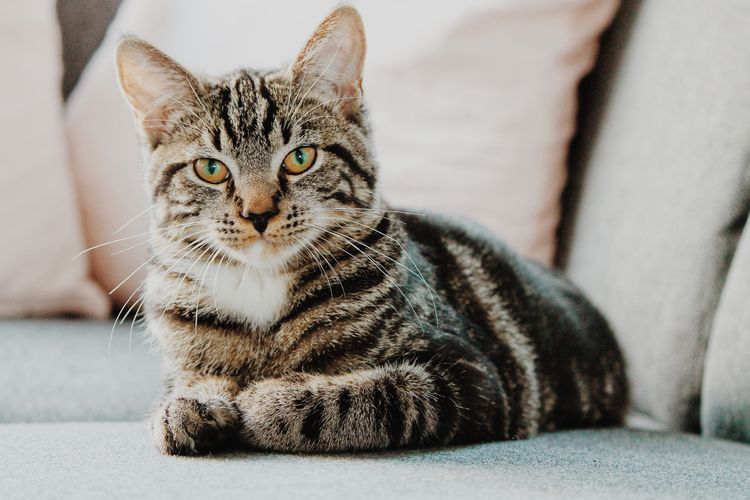

In [ ]:
im=Image.open(whatis)
im